In [1]:
from dask_jobqueue import SLURMCluster
from dask.distributed import Client

import xarray as xr
import metpy
from metpy.units import units
import iris
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import cfgrib
import xesmf as xe
import pyproj
import ESMF
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

In [2]:
cluster = SLURMCluster()
cluster.scale(1)
client = Client(cluster)

## Bring in the NAM Data (Provides coordinates - both lats/lons and vertical levels)

In [3]:
# Grab NAM Coordinates from reanalysis dataset on Keeling
nam_including_coords_ds = xr.open_dataset('/data/meso/a/jtrapp/formax/namanl_218_20100510_1200_000.grb', engine='cfgrib',
                                           backend_kwargs={
                                                            'filter_by_keys': {'cfName': 'eastward_wind', 'typeOfLevel': 'isobaricInhPa'},
                                                            'errors': 'ignore'
                                                            }
                                         )
ds_out = nam_including_coords_ds.rename({'isobaricInhPa': 'plev', 'longitude': 'lon', 'latitude': 'lat'})

In [4]:
base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/namanl/'
dt = datetime(2009, 5, 7, 18)
nam_data = xr.open_dataset('{}{dt:%Y%m}/{dt:%Y%m%d}/namanl_218_{dt:%Y%m%d}_'
                       '{dt:%H}00_000.grb'.format(base_url, dt=dt),
                       decode_times=True)

nam_temp = nam_data.metpy.parse_cf('Temperature_isobaric')[0]
nam_crs = nam_temp.metpy.cartopy_crs

## Create Functions to Calculate Climate Change Deltas

In [5]:
def monthly_average(ds_in, variable, start_year=1990, end_year=1999, month_num=5):
    """
    Takes the input xarray dataset, converts the times from cftimes to
    datetime objects. It then subsets the time based on the given years, 
    and calculates the monthly averages
    """
    
    # Subsets times based on given years
    ds_in = ds_in[variable].sel(time = slice(str(start_year)+'-'+str('%.2i'%month_num),str(end_year)+'-'+str('%.2i'%month_num), 12),)
    
    # Find the monthly average
    mon_avg= ds_in.mean('time', skipna=True)
    
    mon_avg_ds = mon_avg.to_dataset()
    
    # Setup the regridder - keek reuse_weights = True to use the regridder in the directory
    regridder = xe.Regridder(mon_avg_ds, ds_out, 'bilinear', reuse_weights=True)

    return regridder(mon_avg_ds)

def climo_delta_2d_miroc(variable):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/MIROC/'
    
    # Path to the historical data
    end_path_historical = '_Amon_MIROC5_historical_r1i1p1_185001-201212.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Amon_MIROC5_rcp85_r1i1p1_200601-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()

    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()
    
    return (monthly_average(future_ds, variable, 2090, 2099) - monthly_average(past_ds, variable)).fillna(0)

def climo_delta_2d_gfdl(variable):
    # Path to the directory containing the MIROC dataset
    directory_path = '/data/jtrapp/a/jtrapp/CMIP5/GFDL/'
    
    # End path for the historical 3d variables
    end_path_historical1 = '_Amon_GFDL-CM3_historical_r1i1p1_199001-199412.nc'
    end_path_historical2 = '_Amon_GFDL-CM3_historical_r1i1p1_199501-199912.nc'

    # End path for the future 3d variables
    end_path_future1 = '_Amon_GFDL-CM3_rcp85_r1i1p1_209101-209512.nc'
    end_path_future2 = '_Amon_GFDL-CM3_rcp85_r1i1p1_209601-210012.nc'
    
    # Historical U-component of the wind
    past_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_historical1).metpy.parse_cf(),
                               xr.open_dataset(directory_path + variable + end_path_historical2).metpy.parse_cf()], dim='time')

    # Future U-component of the wind
    future_ds = xr.concat([xr.open_dataset(directory_path + variable + end_path_future1).metpy.parse_cf(),
                           xr.open_dataset(directory_path + variable + end_path_future2).metpy.parse_cf()], dim='time')

    return (monthly_average(future_ds, variable, 2091, 2099) - monthly_average(past_ds, variable)).fillna(0)

def climo_delta_2d_ncar(variable):
    # Path to the directory containing the MIROC dataset
    first_path = '/data/jtrapp/a/jtrapp/CMIP5/NCAR/'
    
    # Path to the historical data
    end_path_historical = '_Amon_CCSM4_historical_r1i1p1_185001-200512.nc'
 
    # Path to the future projections (RCP 8.5)
    end_path_future = '_Amon_CCSM4_rcp85_r1i1p1_200601-210012.nc'

    # Historical U-component of the wind
    past_ds = xr.open_dataset(first_path + variable + end_path_historical).metpy.parse_cf()

    # Future U-component of the wind
    future_ds = xr.open_dataset(first_path + variable + end_path_future).metpy.parse_cf()

    return (monthly_average(future_ds, variable, 2090, 2099) - monthly_average(past_ds, variable)).fillna(0)

## Setup the 2-D Atmospheric Variables with their standard names

In [6]:
# Variables that are used 
variables = ['uas','vas','tas','hurs','huss','ts','ps','psl']

# CF compliant variables name that match the NAM field names
cf_names = {'uas':'10 metre U wind component',
            'vas':'10 metre V wind component',
            'tas':'2 metre temperature',
            'hurs':'Relative humidity',
            'huss':'specific_humidity', # Not sure how to incoporate this into NAM vars
            'ts':'air_temperature',
            'ps':'surface_air_pressure',
            'psl':'Pressure_reduced_to_MSL_msl'}

## Calculate Climate Change Deltas for the MIROC5 Dataset

In [7]:
# Setup the dataset that everything will be merged with
merged_ds = xr.Dataset()
for var in variables:
    delta_ds = climo_delta_2d_miroc(var).rename({var:cf_names[var]})
    merged_ds = xr.merge([delta_ds, merged_ds], compat='override')

miroc_ds = merged_ds

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable hurs as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable hurs as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable ts as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable ts as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable ps as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable ps as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_128x256_428x614.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.


## Calcualte Climate Change Deltas for the GFDL Dataset

In [8]:
# Setup the dataset that everything will be merged with
merged_ds = xr.Dataset()
for var in variables:
    delta_ds = climo_delta_2d_gfdl(var).rename({var:cf_names[var]})
    merged_ds = xr.merge([delta_ds, merged_ds], compat='override')

gfdl_ds = merged_ds

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable uas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


using dimensions ('lat', 'lon') from data variable vas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable hurs as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable hurs as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable ts as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable ts as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable ps as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable ps as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_90x144_428x614.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.


## Calcualte Climate Change Deltas for the NCAR CCSM Dataset

In [9]:
# Setup the dataset that everything will be merged with
merged_ds = xr.Dataset()
for var in variables:
    try:
        delta_ds = climo_delta_2d_ncar(var).rename({var:cf_names[var]})
        merged_ds = xr.merge([delta_ds, merged_ds], compat='override')
    except:
        continue
ncar_ds = merged_ds

Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable tas as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable hurs as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable hurs as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable huss as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable ts as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable ts as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable
Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable ps as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable ps as the horizontal dimensions for this dataset.


Found lat/lon values, assuming latitude_longitude for projection grid_mapping variable


Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.
Reuse existing file: bilinear_192x288_428x614.nc
using dimensions ('lat', 'lon') from data variable psl as the horizontal dimensions for this dataset.


---
# **Plots**

### Setup a function for creating plots

In [10]:
def surface_plot(ds, model_name):
    """
    Plots surface temperature and u-component of the wind using the climate delta
    datasets
    
    Input:
    
    ds = input datset (ex. miroc_ds) - this contains the climate change deltas
    
    model name = string (name of model ex. MIROC)
    """
    temp_sfc = ds['2 metre temperature'].values
    clevs_temp = np.arange(0, 15.5, 0.5)
 
    wind_sfc = ds['10 metre U wind component'].values
    clevs_wind = np.arange(-3, 3.5, 0.5)

    # Grab the lats and lons
    lons = miroc_ds.lon.values
    lats = miroc_ds.lat.values
    
    
    # Set projection of data (so we can transform for the figure)
    datacrs = ccrs.PlateCarree()

    # Start figure and set extent to be over CONUS
    fig = plt.figure(1, figsize=(14, 12))
    ax = plt.subplot(111, projection=nam_crs)

    # Add coastline and state map features
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
    ax.add_feature(cfeature.STATES.with_scale('50m'))

    # Plot colorfill and dashed contours of 700-hPa temperatures in Celsius
    cf = ax.contourf(lons, lats, temp_sfc, clevs_temp, cmap=plt.cm.hot_r, transform=datacrs)
    cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
    cb.set_label('Temperature (C)')

    # Plot contours of 500-hPa change in zonal wind
    cs = ax.contour(lons, lats, wind_sfc, clevs_wind, colors='black', transform=datacrs)
    plt.clabel(cs, fmt='%d')

    plt.title(model_name +' May Monthly Average (2090-2099 - 1990-1999) \u0394T @ 2m and \u0394U @ 10m')
    plt.savefig(model_name + '_DeltaT_Sfc_DeltaU_Sfc.png')

#### MIROC Surface Temperature and U-Wind

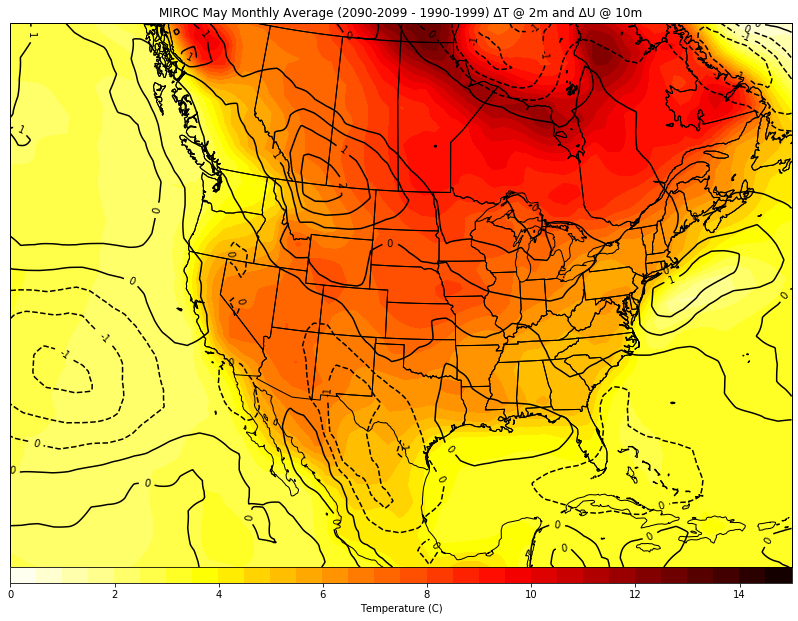

In [11]:
surface_plot(miroc_ds, 'MIROC')

#### GFDL Surface Temperature and U-Wind

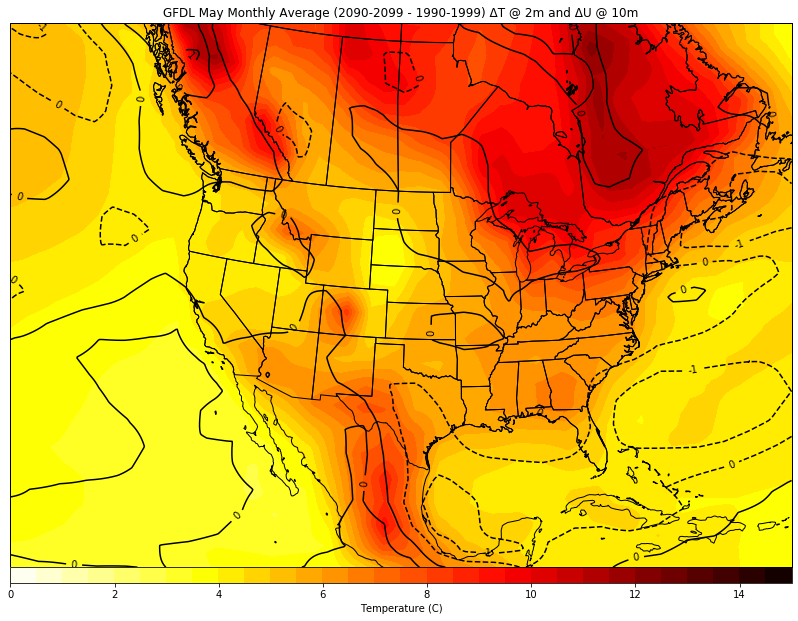

In [12]:
surface_plot(gfdl_ds, 'GFDL')

#### GFDL Surface Temperature and U-Wind

##### Create a seperate plot for the NCAR model since it does not include surface winds

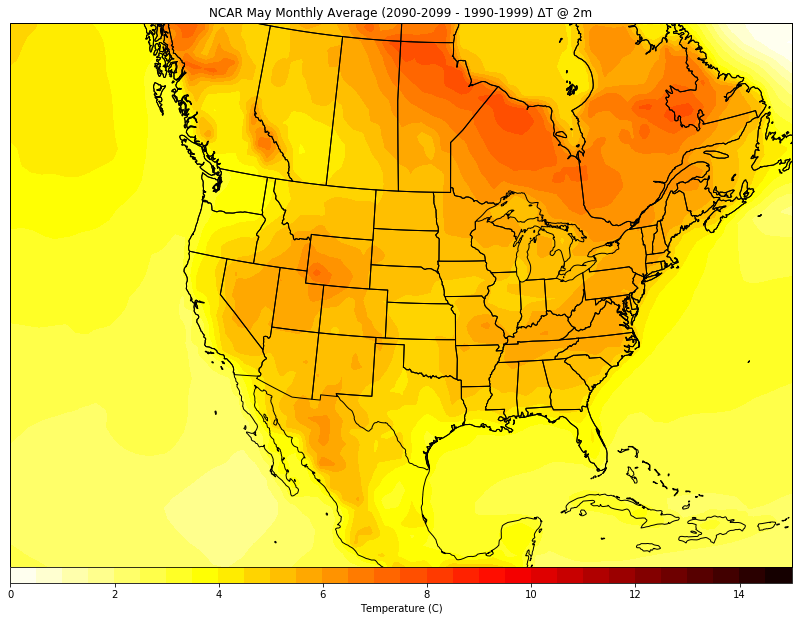

In [13]:
ds = ncar_ds
model_name = 'NCAR'

temp_sfc = ds['2 metre temperature'].values
clevs_temp = np.arange(0, 15.5, 0.5)

# Grab the lats and lons
lons = miroc_ds.lon.values
lats = miroc_ds.lat.values
    
    
# Set projection of data (so we can transform for the figure)
datacrs = ccrs.PlateCarree()

# Start figure and set extent to be over CONUS
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=nam_crs)

# Add coastline and state map features
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))

# Plot colorfill and dashed contours of 700-hPa temperatures in Celsius
cf = ax.contourf(lons, lats, temp_sfc, clevs_temp, cmap=plt.cm.hot_r, transform=datacrs)
cb = plt.colorbar(cf, orientation='horizontal', pad=0, aspect=50)
cb.set_label('Temperature (C)')

plt.title(model_name +' May Monthly Average (2090-2099 - 1990-1999) \u0394T @ 2m')
plt.savefig(model_name + '_DeltaT_Sfc_DeltaU_Sfc.png')

---
## **Write output to a netCDF file**


### Now, let's save our newly created climate change deltas to temporary netCDF files

#### Start with MIROC

In [14]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    miroc_ds = miroc_ds.drop('crs')
except ValueError:
    None

miroc_ds.to_netcdf('../preliminary_netcdf/MIROC_2d_vars.nc')

#### Then GFDL

In [15]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    gfdl_ds = gfdl_ds.drop('crs')
except ValueError:
    None

gfdl_ds.to_netcdf('../preliminary_netcdf/GFDL_2d_vars.nc')

#### And finally NCAR-CCSM

In [16]:
# Check to make sure there is not a coordinate reference system still
# associated with the dataset - or else there will be issues
try:
    ncar_ds = ncar_ds.drop('crs')
except ValueError:
    None
ncar_ds.to_netcdf('../preliminary_netcdf/NCAR_2d_vars.nc')